# Finetuning of a Faster RCNN for object detection

In this task, a [Faster RCNN](https://arxiv.org/abs/1506.01497) for object detection is re-trained on a new dataset.

An intensive use of [PyTorch](https://pytorch.org/)'s functionalities has been used. Among other things, I used a pre-trained network and fine-tune a network with new data.

**Note:** The Notbook was developed on a Linux environment and using Google-Colab. It can lead to unpredictability under Windows. Accordingly, running in Colab is recommended.


When using Google Colab set the flag `USE_COLAB` to `True`.

In [ ]:
USE_COLAB = True

Set the current working directory here if using google colab

In [6]:
curren_dir = '/content/drive/MyDrive/path/to/folder/'

Import all the libraries used.
Please note to set the path to the exercise folder correctly!

In [25]:
import sys
if USE_COLAB:
    from google.colab import drive
    drive.mount('/content/drive/')
    sys.path.append(curren_dir) ## Place correct
else:
    sys.path.append('')

import numpy as np
import cv2
import os
from datetime import datetime

from PIL import Image

import torch
import torchvision

from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torch.utils.data import Dataset, DataLoader, Subset
import torchvision.transforms.functional as F

from sklearn.model_selection import train_test_split
from tqdm import tqdm

from matplotlib import pyplot as plt
import pickle

import pandas as pd
import glob as glob
import random

NameError: name 'USE_COLAB' is not defined

## 1. Detection with a pre-trained model

Selecting the device (CPU or GPU) on which to run the infernce and training.
This notebook is set to use the GPU under Google Colab.

Download the pre-trained **Faster R-CNN** with ResNet50 Backbone, on the COCO dataset.

In [8]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print("We use the following device: ", device)
# load a model; pre-trained on COCO
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights='COCO_V1').to(device)

We use the following device:  cuda


NameError: name 'torchvision' is not defined

Transformation of a sample input for infernce.

In [ ]:
def img_transform(img):
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32)
  img /= 255.0
  img = torch.from_numpy(img).permute(2,0,1)
  return img

  Inference of a single input image.

In [ ]:
def inference(img, model, detection_threshold=0.70):
  '''
  Infernece of a single input image

  inputs:
    img: input-image as torch.tensor (shape: [C, H, W])
    model: model for infernce (torch.nn.Module)
    detection_threshold: Confidence-threshold for NMS (default=0.7)

  returns:
    boxes: bounding boxes (Format [N, 4] => N times [xmin, ymin, xmax, ymax])
    labels: class-prediction (Format [N] => N times an number between 0 and _num_classes-1)
    scores: confidence-score (Format [N] => N times confidence-score between 0 and 1)
  '''
  model.eval()

  img = img.to(device)
  outputs = model([img])

  boxes = outputs[0]['boxes'].data.cpu().numpy()
  scores = outputs[0]['scores'].data.cpu().numpy()
  labels = outputs[0]['labels'].data.cpu().numpy()

  boxes = boxes[scores >= detection_threshold].astype(np.int32)
  labels = labels[scores >= detection_threshold]
  scores = scores[scores >= detection_threshold]

  return boxes, scores, labels

Function that draws the BBoxes, scores, and labels on the image.


In [ ]:
import matplotlib.patches as patches

def plot_image(img, boxes, scores, labels, dataset, save_path=None):
  '''
  Function that draws the BBoxes, scores, and labels on the image.

  inputs:
    img: input-image as numpy.array (shape: [H, W, C])
    boxes: list of bounding boxes (Format [N, 4] => N times [xmin, ymin, xmax, ymax])
    scores: list of conf-scores (Format [N] => N times confidence-score between 0 and 1)
    labels: list of class-prediction (Format [N] => N times an number between 0 and _num_classes-1)
    dataset: list of all classes e.g. ["background", "class1", "class2", ..., "classN"] => Format [N_classes]
  '''

  cmap = plt.get_cmap("tab20b")
  class_labels = np.array(dataset)
  colors = [cmap(i) for i in np.linspace(0, 1, len(class_labels))]
  height, width, _ = img.shape
  # Create figure and axes
  fig, ax = plt.subplots(1, figsize=(16, 8))
  # Display the image
  ax.imshow(img)
  for i, box in enumerate(boxes):
    class_pred = labels[i]
    conf = scores[i]
    width = box[2] - box[0]
    height = box[3] - box[1]
    rect = patches.Rectangle(
        (box[0], box[1]),
        width,
        height,
        linewidth=2,
        edgecolor=colors[int(class_pred)],
        facecolor="none",
    )
    # Add the patch to the Axes
    ax.add_patch(rect)
    plt.text(
        box[0], box[1],
        s=class_labels[int(class_pred)] + " " + str(int(100*conf)) + "%",
        color="white",
        verticalalignment="top",
        bbox={"color": colors[int(class_pred)], "pad": 0},
    )

  # Used to save inference phase results
  if save_path is not None:
    plt.savefig(save_path)

  plt.show()

Now, apply the loaded model to new images.

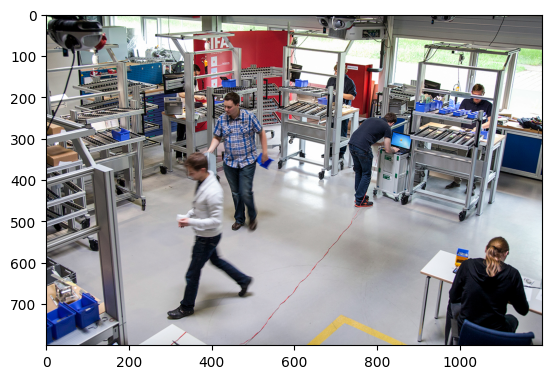

In [ ]:
!wget https://www.uni-hannover.de/fileadmin/luh/studiengaenge/Produktion_und_Logistik_Master/produktion_und_logistik_master.jpg -q -O input.jpg
img = cv2.imread("./input.jpg")
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

Image transformation and execution of the infernce.

In [ ]:
img = img_transform(img)
boxes, scores, labels = inference(img, model)

In the task folder there is a txt file named ``coco-labels``. To draw the label into the image the labels must be known (see `plot_image`). The text block below turns the txt-file into a list with the 91 COCO classes.

In [ ]:
with open(sys.path[-1] + "coco_labels.txt", "r") as coco:
  COCO_LABELS = coco.readlines()

for i, _ in enumerate(COCO_LABELS):
  COCO_LABELS[i] = COCO_LABELS[i].replace("\n", "")

Output image with predictions.

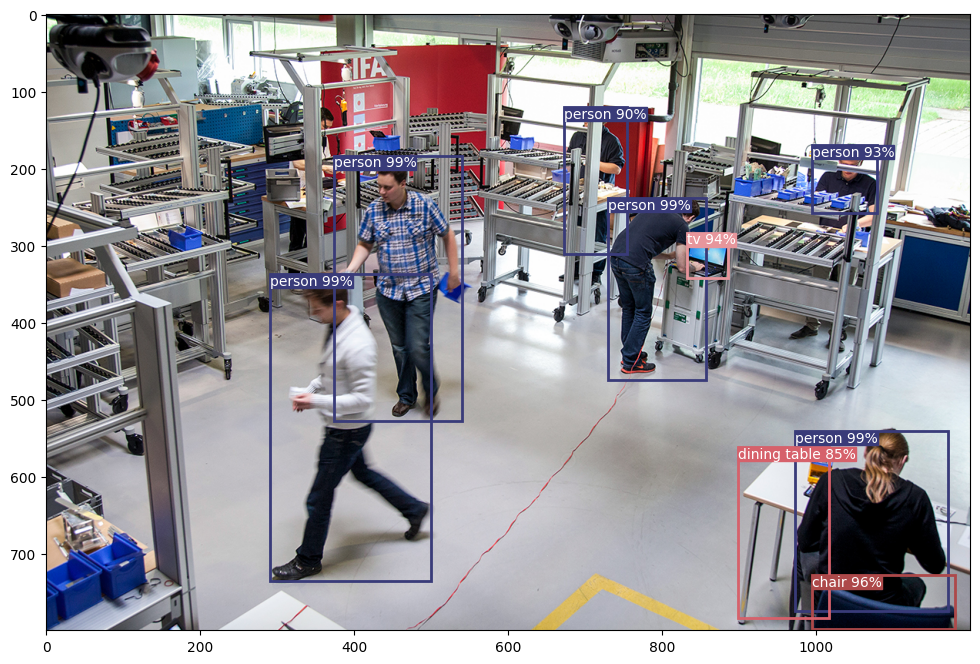

In [ ]:
img = img.cpu().permute(1,2,0).numpy()
plot_image(img, boxes, scores, labels, COCO_LABELS)

## 2. Finetuning of a pre-trained model with new data

Here, we finetune the pre-trained model from above.
For this purpose, we choose a new small dataset specialized in vehicle detection.

Below we download and unpack the dataset for vehicle detection (Created by: https://crowdai.com/).

In [23]:
!wget -nc https://s3.amazonaws.com/udacity-sdc/annotations/object-detection-crowdai.tar.gz
!tar xf object-detection-crowdai.tar.gz

--2025-04-16 21:45:09--  https://s3.amazonaws.com/udacity-sdc/annotations/object-detection-crowdai.tar.gz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 16.182.104.144, 52.217.171.232, 52.217.66.46, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|16.182.104.144|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1650810880 (1.5G) [application/x-gzip]
Saving to: ‘object-detection-crowdai.tar.gz’

object-detection-cr 100%[===================>]   1.54G  14.6MB/s    in 2m 2s   

2025-04-16 21:47:11 (13.0 MB/s) - ‘object-detection-crowdai.tar.gz’ saved [1650810880/1650810880]



Labels for the data set are also included in the exercise folder. The label CSV is read out via pandas and the first lines are displayed. Here you can see the structure of the labels.

In [24]:
df = pd.read_csv(sys.path[-1] + 'labels_crowdai.csv')

NameError: name 'pd' is not defined

Paths to the images and the labels -> For creation of the Pytorch dataset

In [ ]:
path_csv = sys.path[-1] + 'labels_crowdai.csv'
img_dir = 'object-detection-crowdai/'

In [ ]:
df = pd.read_csv(path_csv)
print("Number of total bounding boxes: ", len(df))

image_paths = glob.glob(f"{img_dir}/*.jpg")
all_images = [image_path.split(os.path.sep)[-1] for image_path in image_paths]
all_images = sorted(all_images)
print("Number of unique images: ", len(all_images))

Number of total bounding boxes:  72063
Number of unique images:  9420


### Dataset creation

Use the default dataset of PyTorch to create the dataset class `vehicleDataset` with which the FasterRCNN can be trained. (https://pytorch.org/vision/main/models/faster_rcnn.html)

**Note 1:** There are no labels for some images because they show an 'empty' scene &rarr; these images should be filtered out.

**Note 2:** There are incorrect bounding boxes in the dataset (e.g. `xmax=xmin`).

**Transformations (augmentations)**

In [ ]:
'''
Class that holds all the augmentation related attributes
'''
class Transformation():
    # This provides a random probability of the augmentation to be applied or not
    def get_probability(self):
        return np.random.choice([False, True], replace=False, p=[0.5, 0.5])

    # Increases the contrast by a factor of 2
    def random_adjust_contrast(self, image, enable=None):
        enable = self.get_probability() if enable is None else enable
        return F.adjust_contrast(image, 2) if enable else image

    # Increaes the brightness by a factor of 2
    def random_adjust_brightness(self, image, enable=None):
        enable = enable = self.get_probability() if enable is None else enable
        return F.adjust_brightness(image,2) if enable else image

    # Horizontal flip
    def random_hflip(self, image, boxes, enable=None):
        enable = enable = self.get_probability() if enable is None else enable
        if enable:
          #flip image
          new_image = F.hflip(image)

          #flip boxes
          new_boxes = boxes.clone()
          new_boxes[:, 0] = image.shape[2] - boxes[:, 0]  # image width - xmin
          new_boxes[:, 2] = image.shape[2] - boxes[:, 2]  # image_width - xmax
          new_boxes = new_boxes[:, [2, 1, 0, 3]]          # Interchange the xmin and xmax due to mirroring
          return new_image, new_boxes
        else:
          return image, boxes

**Custom Dataset**

In [ ]:
class vehicleDataset(Dataset):
  def __init__(self, img_path, label_path, classes, transforms=None):
    super().__init__()
    print("Preparing the dataset...")

    self.image_dir = img_path
    self.gt_info = pd.read_csv(label_path)
    self.classes = classes
    self.transforms = transforms

    # Create a list of image file names (in sorted order - this is optional)
    self.image_paths = glob.glob(f"{img_path}/*.jpg")
    all_images = [image_path.split(os.path.sep)[-1] for image_path in self.image_paths]
    self.all_images = sorted(all_images)

    # Map Label (str) --> Label (int)
    for i in range(len(self.gt_info)):
      label = self.gt_info.loc[i, 'Label']
      self.gt_info.loc[i, 'Label'] = self.classes.index(label)

    # Filter the dataset based on given conditions:
    self.filter_dataset()
    print("Dataset prepared")

  def __getitem__(self, idx):
    target = {}

    # Read input image
    image_name = self.all_images[idx]
    image_path = os.path.join(self.image_dir, image_name)
    image = cv2.imread(image_path)
    image = img_transform(image)

    # Fetch GT infos for given image
    gt_info = self.gt_info[self.gt_info['Frame'] == image_name]

    boxes = torch.Tensor(gt_info[['xmin', 'ymin', 'xmax', 'ymax']].values).float()
    labels = torch.LongTensor(gt_info['Label'].values.tolist())

    if self.transforms:
        image = self.transforms.random_adjust_contrast(image, enable=True)
        image = self.transforms.random_adjust_brightness(image, enable=True)
        image, boxes = self.transforms.random_hflip(image, boxes, enable=True)

    target["boxes"] = boxes     # Hint: Shape -> [N, 4] with N = Number of Boxes
    target["labels"] = labels   # Hint: Shape -> [N] with N = Number of Boxes

    return image, target

  def __len__(self):
    return len(self.all_images)

  '''
  Filter the dataset by removing images with no labels and incorrect bounding boxes
  '''
  def filter_dataset(self):
    print("Filtering the dataset...")
    remove_images = []

    # There are no labels for some images because they show an 'empty' scene → these images should be filtered out.
    for image_file in self.all_images.copy():
      if image_file not in self.gt_info['Frame'].values:
        remove_images.append(image_file)
        self.all_images.remove(image_file)
    print("Images removed with no labels: ", len(remove_images))

    # There are incorrect bounding boxes in the dataset (e.g. xmax=xmin).
    valid_box_mask = (self.gt_info['xmax'] - self.gt_info['xmin'] > 0) & (self.gt_info['ymax'] - self.gt_info['ymin'] > 0)
    print("Images removed with incorrect bounding boxes: ", len(self.gt_info) - valid_box_mask.shape[0])
    self.gt_info = self.gt_info[valid_box_mask] # TODO: correct this masking

Testing the created dataset class by running an infernce on random images of the dataset.

In [22]:
crowdai = ["Background", "Car", "Truck", "Pedestrian"]
dataset = vehicleDataset(img_dir, path_csv, crowdai, transforms=Transformation()) # here your arguments
num_images = 5

for _ in range(num_images):
  x = random.randint(0, (dataset.__len__()-1))
  img, target = dataset.__getitem__(x)
  img = img.cpu().permute(1,2,0).numpy()
  boxes = target['boxes'].numpy()
  labels = target['labels'].numpy()
  scores = [1]*len(labels)
  print("Image index: ", x)
  plot_image(img, boxes, scores, labels, crowdai)

NameError: name 'vehicleDataset' is not defined

### Fine-Tune

The Faster RCNN model is now to be trained for 5 epochs on the new dataset. Several tasks have to be done for this.

In [19]:
# Hyperparameters

SEED = 42

TEST_SIZE = 0.2

NUM_EPOCHS = 5

LR = 0.005
LR_MOMENTUM=0.9
LR_DECAY_RATE=0.0005

LR_SCHED_STEP_SIZE = 0.1
LR_SCHED_GAMMA = 0.1

BATCH_SIZE = 16

NUM_TEST_IMAGES = 5
NMS_THRESH = 0.01

Create an output directory to store checkpoints and plots

In [5]:
current_dir = curren_dir if USE_COLAB else os.getcwd()

# Fetch current date and time
now = datetime.now()
dt_string = now.strftime("%d-%m-%Y-%H-%M-%S")
output_dir_name = "output-" + dt_string

OUTPUT_DIR = os.path.join(current_dir, output_dir_name)
os.makedirs(OUTPUT_DIR, exist_ok=True)

NameError: name 'USE_COLAB' is not defined

In [3]:
crowdai = ["Background", "Car", "Truck", "Pedestrian"]

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

model = torchvision.models.detection.fasterrcnn_resnet50_fpn(min_size=300, max_size=480, pretrained=True)
num_classes = 4  # 3 classes + background
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
model.to(device)

num_epochs = NUM_EPOCHS

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=LR, momentum=LR_MOMENTUM, weight_decay=LR_DECAY_RATE)

# create a train- and validation-dataset with our vehicleDataset
# split the dataset in train and test set
dataset = vehicleDataset(img_dir, path_csv, crowdai, transforms=Transformation())      # here your arguments
dataset_test = vehicleDataset(img_dir, path_csv, crowdai, transforms=None)             # here your arguments

torch.manual_seed(SEED)
indices = torch.randperm(len(dataset)).tolist()

test_size = int(len(dataset) * TEST_SIZE)
dataset = torch.utils.data.Subset(dataset, indices[:-test_size])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-test_size:])

# create a learning rate scheduler
# TODO: step size to be tuned !
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, \
                                                step_size=LR_SCHED_STEP_SIZE, \
                                                gamma=LR_SCHED_GAMMA)

def collate_fn(batch):
  return tuple(zip(*batch))

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
  dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2,
  collate_fn=collate_fn)

data_loader_test = torch.utils.data.DataLoader(
  dataset_test, batch_size=1, shuffle=False, num_workers=2,
  collate_fn=collate_fn)


NameError: name 'torchvision' is not defined

Train per epoch, validation loop and plotting function

In [ ]:
'''
Function to train the model over one epoch.
'''
def train_one_epoch(model, optimizer, data_loader, device, epoch):
  train_loss_list = []

  tqdm_bar = tqdm(data_loader, total=len(data_loader))
  for idx, data in enumerate(tqdm_bar):
    optimizer.zero_grad()
    images, targets = data

    images = list(image.to(device) for image in images)
    targets = [{k: v.to(device) for k, v in t.items()} for t in targets]  # targets = {'boxes'=tensor, 'labels'=tensor}

    losses = model(images, targets)

    loss = sum(loss for loss in losses.values())
    loss_val = loss.item()
    train_loss_list.append(loss.detach().cpu().numpy())

    loss.backward()
    optimizer.step()

    tqdm_bar.set_description(desc=f"Training Loss: {loss:.3f}")

  return train_loss_list

'''
Function to validate the model
'''
def evaluate(model, data_loader_test, device):
    val_loss_list = []

    tqdm_bar = tqdm(data_loader_test, total=len(data_loader_test))

    for i, data in enumerate(tqdm_bar):
        images, targets = data

        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        with torch.no_grad():
            losses = model(images, targets)

        loss = sum(loss for loss in losses.values())
        loss_val = loss.item()
        val_loss_list.append(loss_val)

        tqdm_bar.set_description(desc=f"Validation Loss: {loss:.4f}")
    return val_loss_list

'''
Function to plot training and valdiation losses and save them in `output_dir'
'''
def plot_loss(train_loss, valid_loss):
    figure_1, train_ax = plt.subplots()
    figure_2, valid_ax = plt.subplots()

    train_ax.plot(train_loss, color='blue')
    train_ax.set_xlabel('Iteration')
    train_ax.set_ylabel('Training Loss')

    valid_ax.plot(valid_loss, color='red')
    valid_ax.set_xlabel('Iteration')
    valid_ax.set_ylabel('Validation loss')

    figure_1.savefig(f"{OUTPUT_DIR}/train_loss.png")
    figure_2.savefig(f"{OUTPUT_DIR}/valid_loss.png")

Main trian loop over all epochs

In [ ]:
# find latest saved chcekpoint
checkpoint_files = [f for f in os.listdir(OUTPUT_DIR) if f.endswith('.pth')]
if checkpoint_files:
    # Last ckpt file
    checkpoint_files.sort()
    latest_checkpoint = os.path.join(OUTPUT_DIR, checkpoint_files[-1])

    # Load the ckpt
    checkpoint = torch.load(latest_checkpoint)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    start_epoch = checkpoint['epoch']
    loss_dict = checkpoint['loss_dict']
else:
    start_epoch = 0
    loss_dict = {'train_loss': [], 'valid_loss': []}

'''
Train the model over all epochs
'''
for epoch in range(start_epoch, num_epochs):
  print("----------Epoch {}----------".format(epoch+1))

  # Train the model for one epoch
  train_loss_list = train_one_epoch(model, optimizer, data_loader, device, epoch)
  loss_dict['train_loss'].extend(train_loss_list)

  lr_scheduler.step()

  # Run evaluation
  valid_loss_list = evaluate(model, data_loader_test, device)
  loss_dict['valid_loss'].extend(valid_loss_list)

  # Svae the model ckpt after every epoch
  ckpt_file_name = f"{OUTPUT_DIR}/epoch_{epoch+1}_model.pth"
  torch.save({
    'epoch': epoch+1,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss_dict': loss_dict
  }, ckpt_file_name)

  # NOTE: The losses are accumulated over all iterations
  plot_loss(loss_dict['train_loss'], loss_dict['valid_loss'])

# Store the losses after the training in a pickle
with open(f"{OUTPUT_DIR}/loss_dict.pkl", "wb") as file:
    pickle.dump(loss_dict, file)

print("Training Finished !")

### Test Fine-Tuned Model

Test the finetuned FasterRCNN by running an infernce on random images of the validation-dataset.

In [21]:
import random
random.seed(SEED)
crowdai = ["Background", "Car", "Truck", "Pedestrian"]
num_images = NUM_TEST_IMAGES

for _ in range(num_images):
  x = random.randint(0, (dataset_test.__len__()-1))
  img, target = dataset_test.__getitem__(x)
  img = img.to(device)

  # Load last checkpoint
  # CHANGE THE OUTPUT_DIR IF CKPT IS STORED ELSEWHERE
  checkpoint_dir = f"/{OUTPUT_DIR}/epoch_5_model.pth"
  checkpoint = torch.load(checkpoint_dir, map_location=device)
  model.load_state_dict(checkpoint['model_state_dict'])

  boxes, scores, labels = inference(img, model)

  img = img.squeeze(0).cpu().permute(1,2,0).numpy()
  plot_image(img, boxes, scores, labels, crowdai, save_path=f"{OUTPUT_DIR}/inference_{x}.png")

NameError: name 'dataset_test' is not defined

In [9]:
from google.colab import drive
drive.mount('/content/drive')



Mounted at /content/drive


In [10]:
OUTPUT_DIR = "/content/drive/MyDrive/path/to/folder/output-15-04-2025-20-51-19"
checkpoint_path = f"{OUTPUT_DIR}/epoch_5_model.pth"


In [11]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [12]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# Load model without pretrained weights
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights=None)

# Replace the classifier head with the one used during training
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, 4)  # 4 = Background + Car + Truck + Pedestrian

model.to(device)

# Load the trained checkpoint
checkpoint = torch.load(checkpoint_path, map_location=device, weights_only=False)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()



Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 206MB/s]


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=1e-05)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=1e-05)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=1e-05)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=1e-05)
          (relu

In [15]:
import torch
from PIL import Image
import torchvision.transforms as T
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def test_model_on_image(image_path, model, device, class_names, threshold=0.5):
    # Load and preprocess the image
    image = Image.open(image_path).convert("RGB")
    transform = T.Compose([
    T.Resize((512, 512)),  # Adjust to match training input size
    T.ToTensor()
    ])

    img_tensor = transform(image).unsqueeze(0).to(device)

    # Run inference
    model.eval()
    with torch.no_grad():
        predictions = model(img_tensor)

    # Extract predictions
    boxes = predictions[0]['boxes'].cpu()
    scores = predictions[0]['scores'].cpu()
    labels = predictions[0]['labels'].cpu()

    # Visualize results
    plt.figure(figsize=(10, 10))
    plt.imshow(image)
    ax = plt.gca()

    for box, score, label in zip(boxes, scores, labels):
        if score >= threshold:
            x1, y1, x2, y2 = box
            rect = patches.Rectangle((x1, y1), x2 - x1, y2 - y1,
                                     linewidth=2, edgecolor='r', facecolor='none')
            ax.add_patch(rect)
            ax.text(x1, y1, f"{class_names[label]}: {score:.2f}",
                    bbox=dict(facecolor='yellow', alpha=0.5))

    plt.axis("off")
    plt.show()


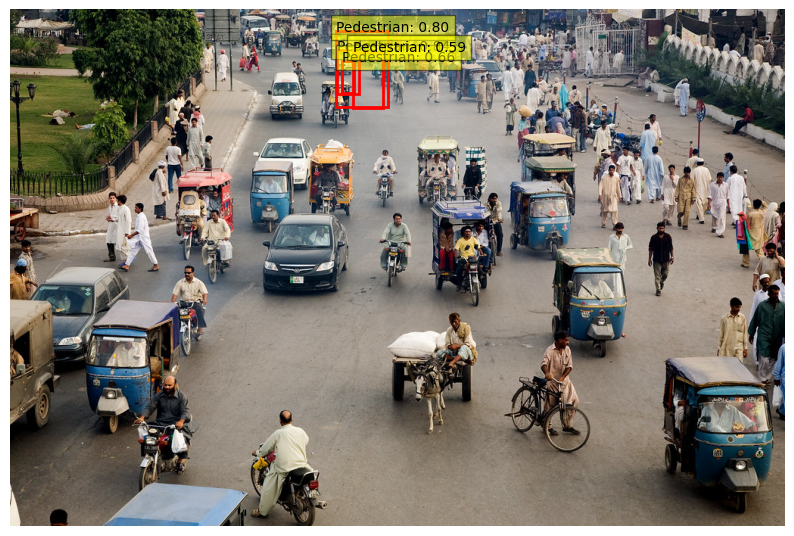

In [17]:

class_names = ["Background", "Car", "Truck", "Pedestrian"]

# Path to your test image (replace this with your actual image path)
image_path = "/image.jpg"

test_model_on_image(image_path, model, device, class_names, threshold=0.5)
